In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses warnings and info logs

import warnings
warnings.filterwarnings("ignore")

import string
import pandas as pd
import numpy as np
from tqdm import tqdm  

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import re
import torch


import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

import pickle



In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/
!unzip /usr/share/nltk_data/corpora/stopwords.zip -d /usr/share/nltk_data/corpora/


In [2]:
import spacy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

nlp = spacy.load("en_core_web_sm")  

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Read and Visualize Data

In [3]:
train_csv = pd.read_csv("/kaggle/input/nnprojectdataset/train.csv")
train_csv.head()

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",Sports
1,2,All your Search ends with this link.,STEM
2,3,"No, the program you're using is made to be com...",STEM
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,5,"No, but not because of why you might think. Wh...",Politics


In [6]:
train_csv.shape

(24989, 3)

In [4]:
test_csv = pd.read_csv("/kaggle/input/testtestdata/WednesdayTest.csv")
test_csv.head()

,SampleID,Discussion
0,1,Possibly he is a misspelling of the hero of Ay...
1,2,Like anal fisting teens?
2,3,Look into these sites:\nhttp://www.ukparks.com...
3,4,"NOVEMBER 03, 2004 (IDG NEWS SERVICE) - An anon..."
4,5,Of course they take a SMALL commissioned rate ...


Category
STEM                5530
Market & Economy    5530
Sports              5529
Politics            4200
Media               4200
Name: count, dtype: int64


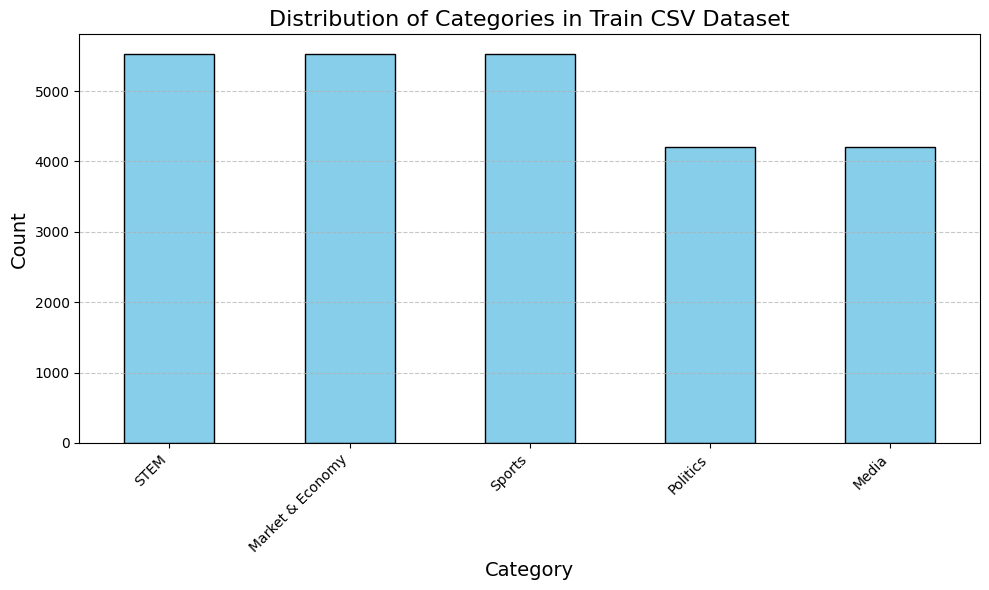

In [5]:
category_counts = train_csv['Category'].value_counts()
print(category_counts)

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Categories in Train CSV Dataset", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Preprocessing

* Check for Missing Values
* Remove Duplicates (Train Only)
* Drop SampleID Column 
* Clean Text
* Remove Stopwords
* Encode Category Column

### 1- Check for missing values


In [6]:

print("Missing Values in Training Dataset:")
print(train_csv.isnull().sum())

print("\nMissing Values in Test Dataset:")
print(test_csv.isnull().sum())

train_csv = train_csv.fillna('')
print("\nMissing Values in Train Dataset After Filling:")
print(train_csv.isnull().sum())

test_csv = test_csv.fillna('')
print("\nMissing Values in Test Dataset After Filling:")
print(test_csv.isnull().sum())

Missing Values in Training Dataset:
SampleID        0
Discussion    343
Category        0
dtype: int64

Missing Values in Test Dataset:
SampleID      0
Discussion    0
dtype: int64

Missing Values in Train Dataset After Filling:
SampleID      0
Discussion    0
Category      0
dtype: int64

Missing Values in Test Dataset After Filling:
SampleID      0
Discussion    0
dtype: int64


### 2- Remove Duplicates (Train Only)

In [7]:
num_duplicates = train_csv['Discussion'].duplicated().sum()
print("Number of Duplicate Rows in Discussion (Before): ", num_duplicates)

train_csv = train_csv.drop_duplicates(subset=['Discussion'])
num_duplicates = train_csv['Discussion'].duplicated().sum()

print("Number of Duplicate Rows in Discussion (After): ", num_duplicates)

Number of Duplicate Rows in Discussion (Before):  494
Number of Duplicate Rows in Discussion (After):  0


### 3- Dropping SampleID column

In [8]:
train_csv.drop(columns ='SampleID', axis=1, inplace=True)
train_csv.head()

,Discussion,Category
0,"Without sitting down and doing it manually, yo...",Sports
1,All your Search ends with this link.,STEM
2,"No, the program you're using is made to be com...",STEM
3,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,"No, but not because of why you might think. Wh...",Politics


### 4- Clean Text

In [9]:
def normalize_repeated_chars(word):
    repeat_regexp = re.compile(r'(.)\1{2,}')  # Match characters repeated 3 or more times
    word = repeat_regexp.sub(r'\1', word)  # Replace them with a single occurrence
    return word
    
def preprocess_text(text):
    # (handles NaN or other types)
    if not isinstance(text, str):
        return ""
    # Dictionary of contractions
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                        "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                        "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                        "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                        "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                        "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                        "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                        "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                        "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                        "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                        "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                        "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                        "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                        "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                        "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                        "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                        "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                        "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                        "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                        "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                        "you're": "you are", "you've": "you have"}


    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re  

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    text = replace_contractions(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)  
    # Remove user mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    # Replace weird things like \n
    text = re.sub(r'\\n', ' ', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Normalize repeated characters (e.g., "noooooooooooo" -> "no")
    words = text.split()
    words = [normalize_repeated_chars(word) for word in words]
    text = " ".join(words)

    emoticon_pattern = re.compile(r"[:;=8xX]-?[)D(P/\\\|]") 
    text = emoticon_pattern.sub(r'', text)

    # Tokenize and lemmatize using SpaCy
    doc = nlp(text)  # Apply lemmatization after correction
    lemmatized_text = " ".join([token.lemma_ for token in doc if token.text not in stopwords.words('english')])
    
    return lemmatized_text.lower()

sample_text = "Heeeeeelloooooo!!!! This is a testtttt email: example@test.com with :) ;-) i'm y'all  @sos a \n\n URL: https://example.com"
processed_text = preprocess_text(sample_text)


In [10]:
tqdm.pandas()
train_csv['Discussion'] = train_csv['Discussion'].progress_apply(preprocess_text)
test_csv['Discussion'] = test_csv['Discussion'].progress_apply(preprocess_text)



100%|██████████| 43/43 [00:00<00:00, 59.21it/s]


In [11]:
train_csv.head()

,Discussion,Category
0,without sit manually might try scheduling soft...,Sports
1,all search end link,STEM
2,no program use make compatible dvdrom drive th...,STEM
3,mike woicik the correct answer mike woicik sup...,Sports
4,no might think when profile something tend mis...,Politics


In [12]:
test_csv.head()

,SampleID,Discussion
0,1,possibly misspelling hero ayn rands novel atla...
1,2,like anal fisting teen
2,3,look site
3,4,november idg news service an anonymous group m...
4,5,of course take small commission rate sell some...


### 5- Removing Stop Words

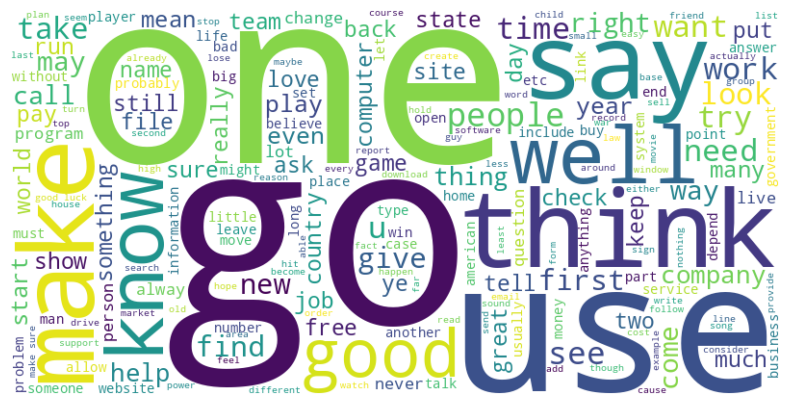

In [13]:
from wordcloud import WordCloud

text = ' '.join(train_csv['Discussion'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [ ]:
stop = stopwords.words('english')
custom_stopwords = set(stop) - {'not', 'no', 'but'}  # Remove from stopwords 'not', 'no', 'but'
custom_stopwords = custom_stopwords.union({'use', 'one', 'go', 'think', 'make'})  
train_csv['Discussion'] = train_csv['Discussion'].astype(str).apply(lambda z: " ".join(z for z in z.lower().split() if z not in custom_stopwords))
test_csv['Discussion'] = test_csv['Discussion'].astype(str).apply(lambda z: " ".join(z for z in z.lower().split() if z not in custom_stopwords))



### 6- Encoding Category column

In [15]:
train_csv['Category'] = train_csv['Category'].replace(
    ['Sports', 'STEM', 'Politics', 'Media', 'Market & Economy'], 
    [1, 4, 0, 2, 3]
)
train_csv.head()

,Discussion,Category
0,without sit manually might try scheduling soft...,1
1,search end link,4
2,no program compatible dvdrom drive possibility...,4
3,mike woicik correct answer mike woicik super b...,1
4,no might profile something tend miss fit profi...,0


# Split to Train / Validation sets

In [16]:
Xtrain , Xtest, Ytrain ,Ytest = train_test_split(train_csv['Discussion'],train_csv['Category'], test_size=0.2, random_state=42)

# Analysis

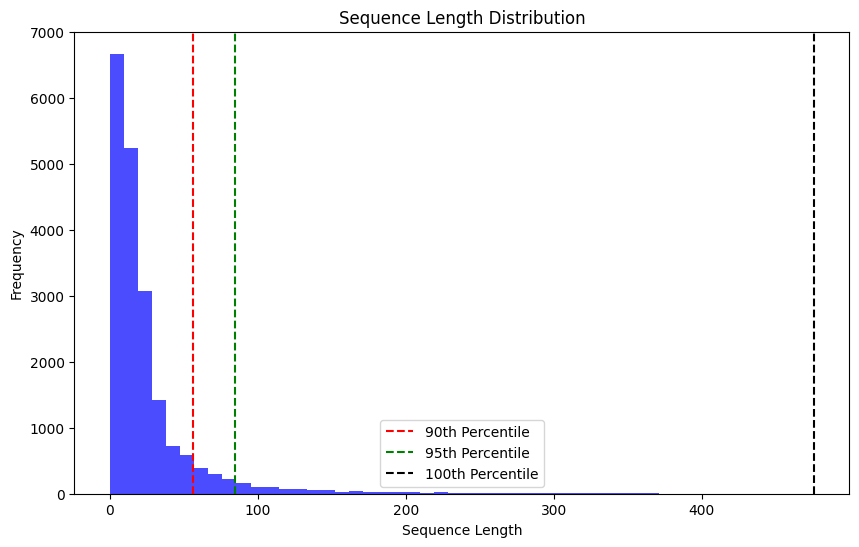

Chosen MAX_SEQUENCE_LENGTH: 476


In [17]:
seq_lengths = [len(text.split()) for text in Xtrain]

plt.figure(figsize=(10,6))
plt.hist(seq_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(np.percentile(seq_lengths, 90), color='r', linestyle='--', label="90th Percentile")
plt.axvline(np.percentile(seq_lengths, 95), color='g', linestyle='--', label="95th Percentile")
plt.axvline(np.percentile(seq_lengths, 100), color='k', linestyle='--', label="100th Percentile")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution")
plt.legend()
plt.show()

MAX_SEQUENCE_LENGTH = int(np.percentile(seq_lengths, 100))
print(f"Chosen MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")


# Helper Functions

In [18]:
def generate_predictions(model, data, output_file):

    predictions = model.predict(data)
    predicted_classes = predictions.argmax(axis=1)

    sample_ids = np.arange(1, len(predicted_classes) + 1)
    
    output_df = pd.DataFrame({
        "SampleID": sample_ids,
        "Category": predicted_classes
    })
    
    output_df.to_csv(output_file, index=False)
    print(output_df.head())


In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history, model, test_data, Ytest):

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [20]:
def evaluate_model(model, test_data, y_test):
    loss, accuracy = model.evaluate(test_data, Ytest)    
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_train_data(X_train, vocab_size, maxlen):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
    
    return X_train_padded, tokenizer


In [22]:
def preprocess_test_data(X_test, tokenizer, maxlen):
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)
    return X_test_padded

# Tokenizing 

In [23]:
max_words = 50000
xtrain_pad, tokenizer = preprocess_train_data(Xtrain, max_words, MAX_SEQUENCE_LENGTH)
xtest_pad = preprocess_test_data(Xtest, tokenizer, MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index

In [57]:
# Save tokenizer, preprocessed training data, and other variables
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('word_index.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

# Save preprocessed data (if needed)
with open('xtrain_pad.pkl', 'wb') as f:
    pickle.dump(xtrain_pad, f)

with open('xtest_pad.pkl', 'wb') as f:
    pickle.dump(xtest_pad, f)

# Embedding

### word2vec

In [ ]:
import gensim
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

vocab_size = len(tokenizer.word_index) + 1  # +1 because we include the padding token
word2vec_embedding_matrix = np.zeros((vocab_size, 300))

for word, index in tqdm(tokenizer.word_index.items(), desc="Populating embedding matrix", total=len(tokenizer.word_index)):
    if word in word2vec_model:
        word2vec_embedding_matrix[inde
        x] = word2vec_model[word]

### fasttext

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

# Load FastText unsupervised word vectors using KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format('/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec', binary=False)

# Now you can access the vectors, for example:
fasttext_embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, index in tqdm(tokenizer.word_index.items(), desc="Populating embedding matrix", total=len(tokenizer.word_index)):
    if word in fasttext_model:
        fasttext_embedding_matrix[index] = fasttext_model[word]
    else:
        fasttext_embedding_matrix[index] = np.random.randn(EMBEDDING_DIM)  # For OOV words'''

### GloVe

In [24]:
embedding_vectors = {}

# Count the total number of lines for the progress bar
file_path = '/kaggle/input/glove42b300dtxt/glove.42B.300d.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    total_lines = sum(1 for _ in file)

# Load the GloVe embeddings with a progress bar
with open(file_path, 'r', encoding='utf-8') as file:
    for row in tqdm(file, total=total_lines, desc="Loading GloVe Embeddings"):
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights

print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Loading GloVe Embeddings: 100%|██████████| 1917494/1917494 [02:16<00:00, 14082.36it/s]

Size of vocabulary in GloVe: 1917494


In [25]:
#initialize the embedding_matrix with zeros
emb_dim = 300  #(lazm 300 3shan el GloVe 300d)
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['cbsmw', 'toolsinternet', 'aiyyayayayayaya', 'jimmyshaft', 'grantsgov']


In [26]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

8908 out of 50000 words were OOV.


In [27]:
print(f"Shape of train_data: {xtrain_pad.shape}") # Should be (num_samples, MAX_SEQUENCE_LENGTH)
print(f"Shape of test_data: {xtest_pad.shape}")
print(f"Shape of Ytrain: {Ytrain.shape}")
print(f"Shape of Ytest: {Ytest.shape}")


Shape of train_data: (19596, 476)
Shape of test_data: (4899, 476)
Shape of Ytrain: (19596,)
Shape of Ytest: (4899,)


# Models

what will be given to the model:
* input_dim = vocab_size (calculated using GloVe)
*  weights=[embedding_matrix] (from GloVe too)

In [28]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.layers import  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D


## Simple RNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
rnn_model1 = Sequential()

# Embedding layer
#rnn_model1.add(Embedding(input_dim=vocab_len, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)

rnn_model1.add(Embedding(input_dim=vocab_len, output_dim=300, input_length=MAX_SEQUENCE_LENGTH,  trainable=False, weights=[embedding_matrix]))

# Simple RNN layer
rnn_model1.add(SimpleRNN(64, activation='relu', return_sequences=False))  # Produces a single vector for the entire sequence

# Dropout for regularization
rnn_model1.add(Dropout(0.5))

# Dense layers for classification
rnn_model1.add(Dense(32, activation='relu'))  # Feature extraction
rnn_model1.add(Dense(5, activation='softmax'))  # Output layer for 5 classes

# Compile the model
rnn_model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model
rnn_model1_history = rnn_model1.fit(xtrain_pad, Ytrain, epochs=40, batch_size=32, validation_data=(xtest_pad, Ytest), callbacks=[early_stopping])


Epoch 1/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.3692 - loss: 1.4414 - val_accuracy: 0.6167 - val_loss: 1.0401
Epoch 2/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6412 - loss: 0.9713 - val_accuracy: 0.6618 - val_loss: 0.9110
Epoch 3/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6737 - loss: 0.8959 - val_accuracy: 0.6903 - val_loss: 0.8496
Epoch 4/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6955 - loss: 0.8433 - val_accuracy: 0.6897 - val_loss: 0.8655
Epoch 5/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6971 - loss: 0.8470 - val_accuracy: 0.7006 - val_loss: 0.8392
Epoch 6/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7065 - loss: 0.8049 - val_accuracy: 0.6914 - val_loss: 0.8495
Epoch 7/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7093 - loss: 0.8013 - val_accuracy: 0.6785 - val_loss: 0.8921
Epoch 8/40
613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7029 - loss: 0.8025 - 

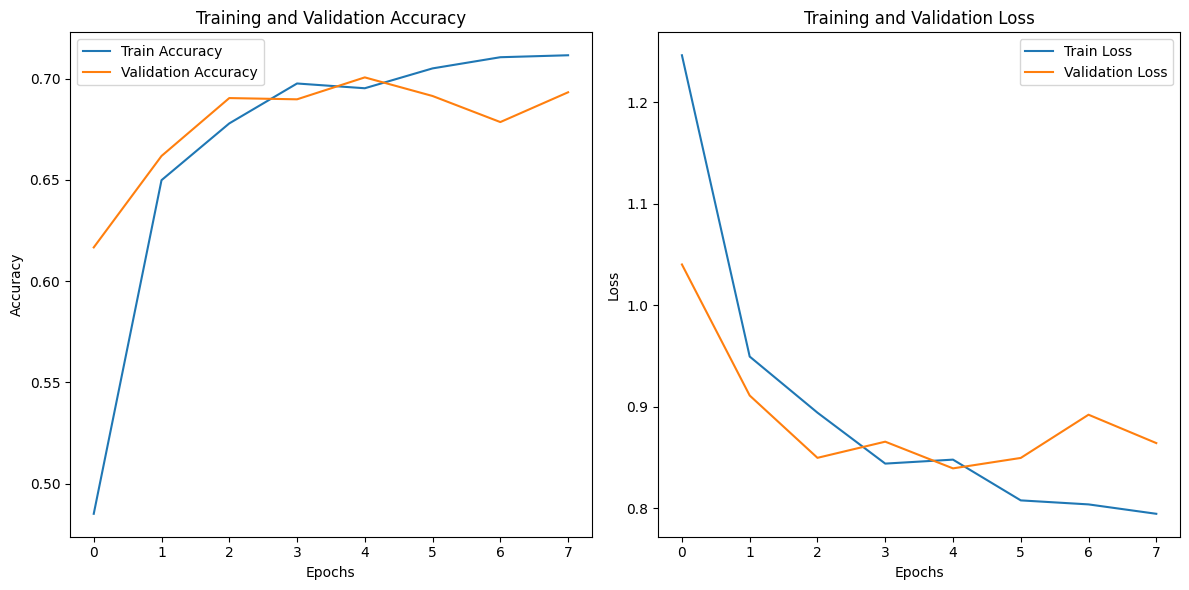

154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7044 - loss: 0.8389
Test Loss: 0.8392, Test Accuracy: 0.7006


In [35]:
plot_training_history(rnn_model1_history, rnn_model1, xtest_pad, Ytest)
evaluate_model(rnn_model1, xtest_pad, Ytest)

In [ ]:
testX = preprocess_test_data(test_csv['Discussion'], tokenizer, MAX_SEQUENCE_LENGTH)
generate_predictions(rnn_model1, testX, "simple_rnn_predctions.csv")

In [36]:
rnn_model1.save('rnn_model1_0.70.h5')

## RNN using LSTM

In [38]:
epochs = 20
batch_size = 32
learning_rate = 0.001

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

rnn_model2 = Sequential()

# Embedding layer
rnn_model2.add(Embedding(vocab_len, emb_dim, trainable=True, weights=[embedding_matrix]))

# LSTM layer
rnn_model2.add(LSTM(128, return_sequences=False))

# Dropout for regularization
rnn_model2.add(Dropout(0.5))

# Dense layer with 5 outputs (one for each class) and softmax activation
rnn_model2.add(Dense(5, activation='softmax'))

# Compile the model with categorical_crossentropy loss
rnn_model2.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(rnn_model2.summary())

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
rnn_model2_history = rnn_model2.fit(xtrain_pad, Ytrain, validation_data=(xtest_pad, Ytest), batch_size = batch_size, epochs = epochs,callbacks=[early_stopping])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 15,000,000 (57.22 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6101 - loss: 1.0099 - val_accuracy: 0.7228 - val_loss: 0.7528
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7655 - loss: 0.6412 - val_accuracy: 0.7234 - val_loss: 0.7472
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8400 - loss: 0.4455 - val_accuracy: 0.7063 - val_loss: 0.8250
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8926 - loss: 0.2995 - val_accuracy: 0.6989 - val_loss: 0.9487
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9213 - loss: 0.2088 - val_accuracy: 0.6914 - val_loss: 1.1274


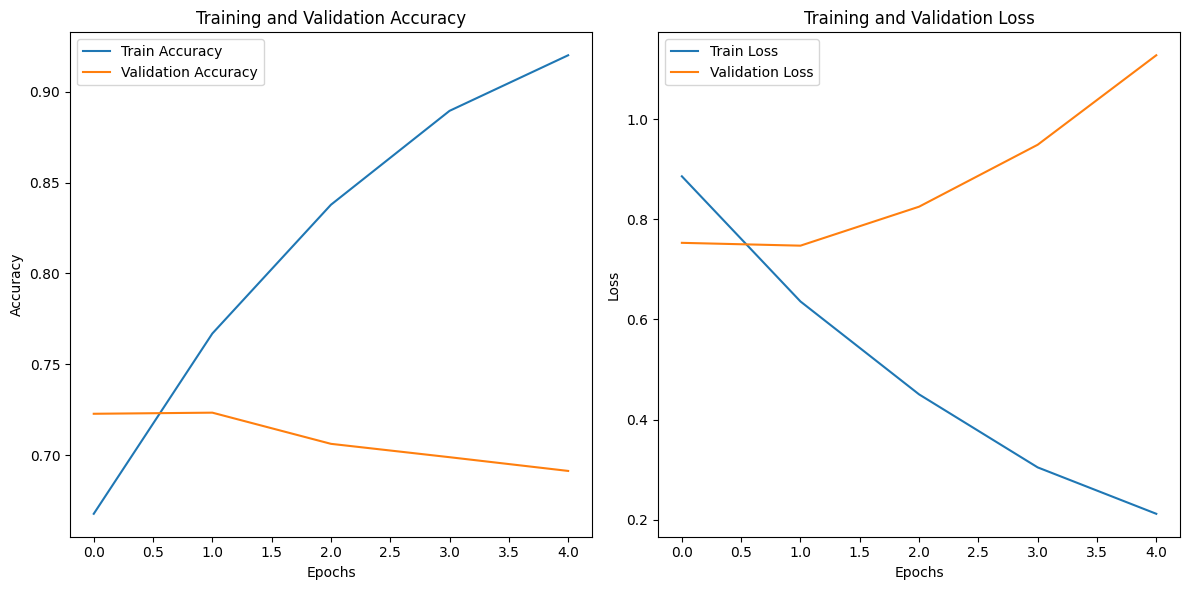

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7301 - loss: 0.7346
Test Loss: 0.7472, Test Accuracy: 0.7234


In [42]:
plot_training_history(rnn_model2_history, rnn_model2, xtest_pad, Ytest)
evaluate_model(rnn_model2, xtest_pad, Ytest)


In [ ]:
testX = preprocess_test_data(test_csv['Discussion'], tokenizer, MAX_SEQUENCE_LENGTH)
generate_predictions(rnn_model2, testX, "rnn_model2_predctions.csv")

In [56]:
rnn_model2.save('rnn_model2_0.723.h5')  # Save model to a file

## CNN

In [ ]:
epochs = 20
batch_size = 32
learning_rate = 0.001

In [46]:
#Embedding layer -> covert seq to dense vector
cnn_model = Sequential([
      Embedding(input_dim=vocab_len, output_dim=emb_dim, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True),
      Conv1D(filters=128, kernel_size=5, activation="relu"),
      GlobalMaxPooling1D(),
      Dropout(0.5),  
      Dense(64, activation='relu')	,
      Dense(5, activation="softmax")
])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(xtrain_pad, Ytrain, validation_data=(xtest_pad, Ytest), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])



Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5548 - loss: 1.1217 - val_accuracy: 0.7083 - val_loss: 0.7784
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7406 - loss: 0.6948 - val_accuracy: 0.7171 - val_loss: 0.7666
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8010 - loss: 0.5422 - val_accuracy: 0.7155 - val_loss: 0.7898
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8475 - loss: 0.4148 - val_accuracy: 0.7063 - val_loss: 0.8619
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8810 - loss: 0.3125 - val_accuracy: 0.7081 - val_loss: 0.9688
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9031 - loss: 0.2571 - val_accuracy: 0.7079 - val_loss: 1.0696
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9130 - loss: 0.2304 - val_accuracy: 0.6985 - val_loss: 1.2302


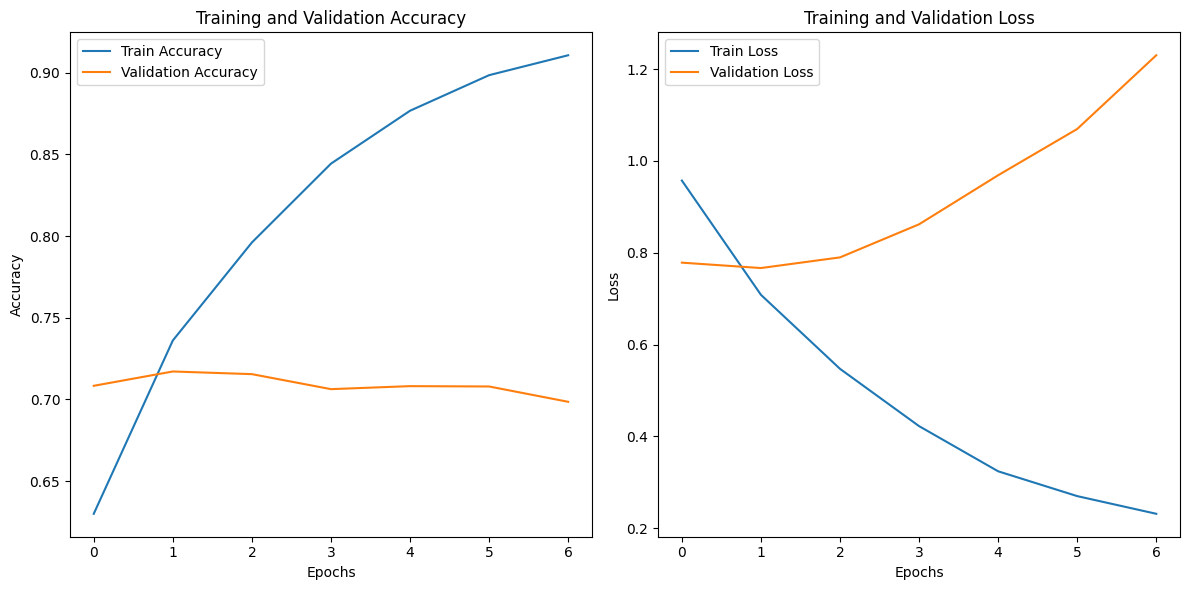

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7233 - loss: 0.7562
Test Loss: 0.7666, Test Accuracy: 0.7171


In [47]:
plot_training_history(cnn_history, cnn_model, xtest_pad, Ytest)
evaluate_model(cnn_model, xtest_pad, Ytest)

In [ ]:
testX = preprocess_test_data(test_csv['Discussion'], tokenizer, MAX_SEQUENCE_LENGTH)
generate_predictions(cnn_model, testX, "CNN_predctions.csv")


In [50]:
cnn_model.save('cnn_model_0.717.h5')  # Save model to a file

## Transformers

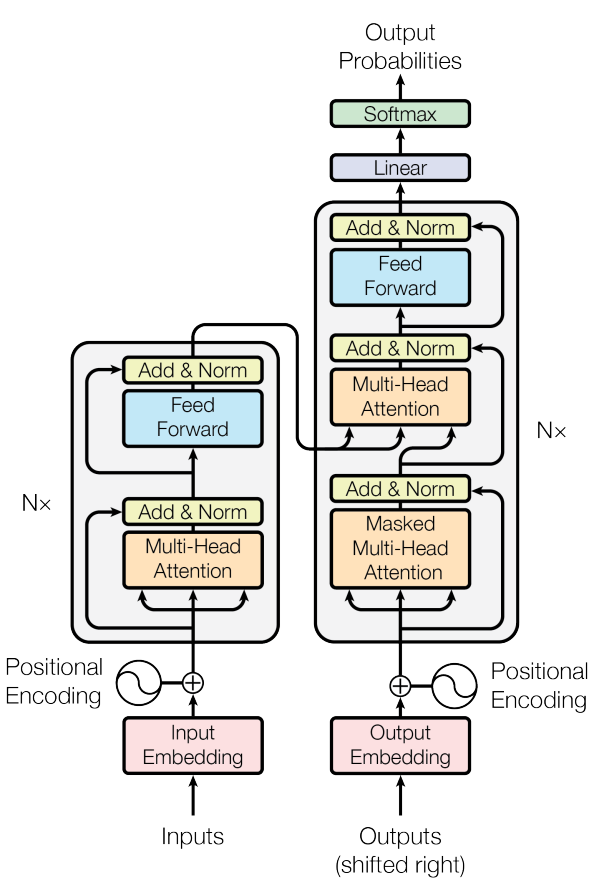

In [30]:
def get_positional_encoding(seq_len, embed_dim):
    positional_encoding = np.zeros((seq_len, embed_dim))

    for pos in tqdm(range(seq_len), desc="Generating Positional Encoding"):
        for i in range(embed_dim):
            angle = pos / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
            if i % 2 == 0:
                positional_encoding[pos, i] = np.sin(angle)  # Apply sine to even indices
            else:
                positional_encoding[pos, i] = np.cos(angle)  # Apply cosine to odd indices
    return tf.cast(positional_encoding, dtype=tf.float32)


In [31]:
NUM_HEADS = 2
dropout_rate = 0.2
learning_rate = 0.0001
epochs = 30
batch_size = 16
n = 3

In [32]:

inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=vocab_len, 
                            output_dim=emb_dim, 
                            weights = [embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=True)(inputs)


# Input Embedding + Positional Encoding
positional_encoding = get_positional_encoding(MAX_SEQUENCE_LENGTH, emb_dim)
embedding_layer = embedding_layer + positional_encoding


# Repeat the Transformer block `n` times
for _ in range(n):
    # Attention mechanism
    attention_output = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=emb_dim)(embedding_layer, embedding_layer, embedding_layer)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Add & Norm (After Attention)
    out1 = LayerNormalization(epsilon=1e-8)(embedding_layer + attention_output)

    # Feed Forward
    # Feed Forward (with consistent dimensions)
    ffn_output = Dense(emb_dim, activation='relu')(out1)  # Ensure output is the same as EMBEDDING_DIM
    ffn_output = Dense(emb_dim)(ffn_output)  # Output layer with EMBEDDING_DIM
    ffn_output = Dropout(dropout_rate)(ffn_output)

    # Add & Norm (After FFN)
    embedding_layer = LayerNormalization(epsilon=1e-8)(out1 + ffn_output)


x = GlobalAveragePooling1D()(embedding_layer)

# Output layer
outputs = Dense(5, activation='softmax')(x)  


transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

transformer_model_history = transformer_model.fit(xtrain_pad, Ytrain, validation_data=(xtest_pad, Ytest), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])


Generating Positional Encoding: 100%|██████████| 476/476 [00:00<00:00, 691.29it/s]


Epoch 1/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.4909 - loss: 1.2123 - val_accuracy: 0.6781 - val_loss: 0.8661
Epoch 2/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.6902 - loss: 0.8265 - val_accuracy: 0.6985 - val_loss: 0.8015
Epoch 3/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.7165 - loss: 0.7357 - val_accuracy: 0.7003 - val_loss: 0.8118
Epoch 4/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.7452 - loss: 0.6800 - val_accuracy: 0.6963 - val_loss: 0.8162
Epoch 5/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.7583 - loss: 0.6350 - val_accuracy: 0.7163 - val_loss: 0.7916
Epoch 6/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.7877 - loss: 0.5646 - val_accuracy: 0.6950 - val_loss: 0.8623
Epoch 7/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.8105 - loss: 0.5155 - val_accuracy: 0.6932 - val_loss: 0.9332
Epoch 8/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.8318 -

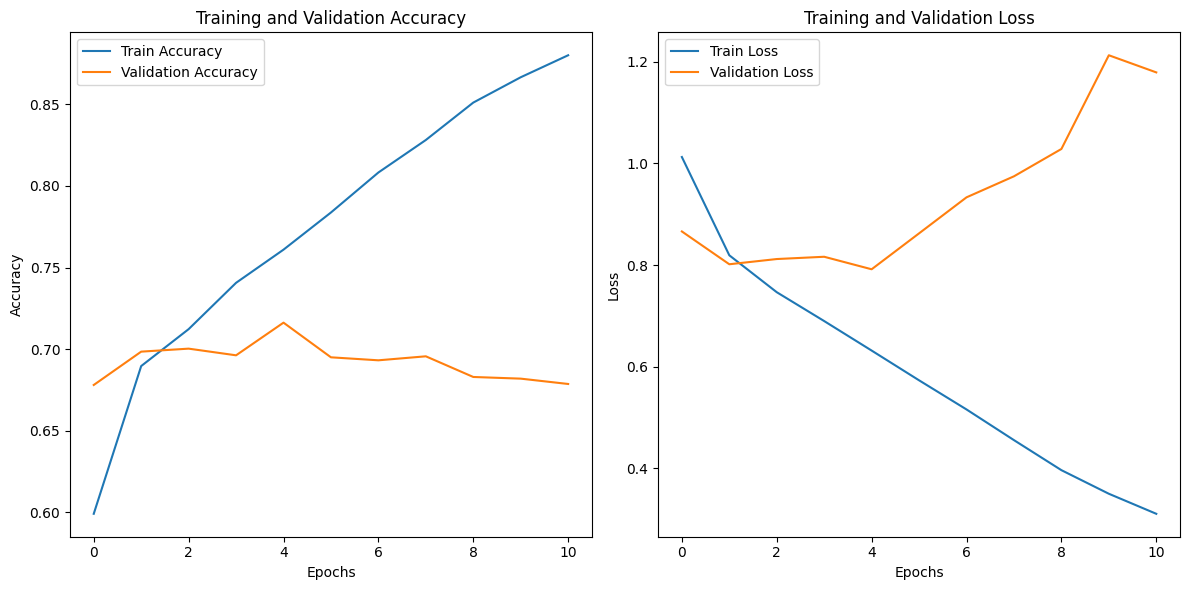

154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7201 - loss: 0.7784
Test Loss: 0.7916, Test Accuracy: 0.7163


In [33]:
plot_training_history(transformer_model_history, transformer_model, xtest_pad, Ytest)
evaluate_model(transformer_model, xtest_pad, Ytest)

In [36]:
testX = preprocess_test_data(test_csv['Discussion'], tokenizer, MAX_SEQUENCE_LENGTH)
generate_predictions(transformer_model, testX, "transformers_predictions.csv")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
   SampleID  Category
0         1         2
1         2         2
2         3         4
3         4         4
4         5         3


In [62]:
transformer_model.save('transformer_model_0.71.h5')  # Save model to a file